# FAIR metrics - Parkinson's disease in ArrayExpress

by [Serena Bonaretti](https://sbonaretti.github.io), Maastricht University

**Use-case: A researcher filters datasets in ArrayExpress to find the differentially expressed genes in the brain frontal lobe between normal subjects and subjects with Parkinson's disease**   
- *Data*: List of gene name with expression profiles  
- *Metadata*: Parkinson's disease, Organism (homo sapiens), experiment type (transcription profiling by array), type of data (raw data available), anatomy (frontal lobe), sex (male, female)
- *Repository*: https://www.ebi.ac.uk/arrayexpress/ 

User interface for data and metadata: https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-1194/?keywords=%22Parkinson%27s%20disease%22%20&organism=Homo%20sapiens&exptype%5B0%5D=&exptype%5B1%5D=%22array%20assay%22&array=&sortby=raw&sortorder=descending&page=1&pagesize=100

Characteristics of the ArrayExpress API: 
- Documentation at https://www.ebi.ac.uk/arrayexpress/help/programmatic_access.html  
- The API to query the database is a rest API: https://www.ebi.ac.uk/arrayexpress/xml/v3/experiments
  - Output format: XML
- The API to get data is an FTP API: ftp://ftp.ebi.ac.uk/pub/databases/arrayexpress/data/  
  - Output format: csv?

Other characteristics:
- Metadata are separated in two different layers: accessible via:
  - Generic metadata: accessible via rest API  
  - Specific metadata: accessible via FTP API  

In this example querying the generic metadata provides two datasets. We have to query also the specific metadata to select our dataset


---

### Calculating FAIR metrics

[FAIR metrics:](#metrics) 
- [F1. (Meta)data are assigned a globally unique and persistent identifier](#F1) 
- [F2. Data are described with rich metadata](#F2) 
- [F3. Metadata clearly and explicitly include the identifier of the data it describes](#F3)  
- [F4. (Meta)data are registered or indexed in a searchable resource](#F4) 
- [A1. (Meta)data are retrievable by their identifier using a standardized communications protocol](#A1)    
- [A2. Metadata are accessible, even when the data are no longer available](#A2)  
- [I1. (Meta)data use a formal, accessible, shared, and broadly applicable language for knowledge representation](#I1) 
- [I2. Metadata use vocabularies that follow FAIR principles](#I2)  
- [I3. (Meta)data include qualified references to other (meta)data](#I3)   
- [R1.1. (Meta)data are released with a clear and accessible data usage license](#R11)  
- [R1.2. (Meta)data are associated with detailed provenance](#R12)  
- [R1.3. (Meta)data meet domain-relevant community standards](#R13)

[FAIR metric indicator](#indicator)

---

Imports:

In [1]:
import bs4
import os
import pandas as pd
import requests
import xml.etree.ElementTree as ET
from io import StringIO

Variables:

In [2]:
repository_name  = "ArrayExpress"
repository_api   = "https://www.ebi.ac.uk/arrayexpress/xml/v3/experiments"             # to query the database (1st layer metadata)
#repository_ftp   = "ftp://ftp.ebi.ac.uk/pub/databases/arrayexpress/data/experiment/"  # to download the data  (2nd layer metadata)
dataset_download = "https://www.ebi.ac.uk/arrayexpress/xml/v3/files/"
    
google_search  = "https://www.google.com/search?q="
re3data_repos  = "https://www.re3data.org/api/v1/repositories"
re3data_repo   = "https://www.re3data.org/api/v1/repository"
re3data_schema = '{http://www.re3data.org/schema/2-2}' # in the metadata xml

# keywords to search dataset
keywords = []
keywords.append("Parkinson's disease")
keywords.append("transcription profiling by array")
keywords.append("Homo sapiens")
keywords.append("frontal lobe")
keywords.append("male")
keywords.append("female")
keywords.append("normal")
keywords.append("true")


Import R for graph:

In [3]:
# use R to create the plot using ggplot2
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Resources' # put here your own R directory
%load_ext rpy2.ipython

Functions:

In [4]:
def look_for_tag_re3data (root, schema, characteristic):
    
    ''' 
    It extract text corresponding to provided tag in re3data
    '''
    
    # look for content
    text = []

    for i in range (0, len(root[0])):

        # tag
        tag  = root[0][i].tag
        tag  = tag.replace(schema, "")

        if tag == characteristic:            
            if len(root[0][i]) == 0:
                text.append(root[0][i].text)
            else:
                for a in range (0, len(root[0][i])):
                    tag  = root[0][i][a].tag
                    tag  = tag.replace(schema, "") # to improve redeability
                    text.append(root[0][i][a].text)

    return text

In [5]:
def pretty_print_xml (root): 
    '''
    It prints xml with identations
    '''
    
    count = 0
    for i in range (0, len(root)):

        if len(root[i]) == 0:
            print ("<"  + str(root[i].tag) + ">")
            print ("   " + str(root[i].text))
            count = count + 1
        else: 
            for j in range(0, len(root[i])):
                if len(root[i][j]) == 0:
                    print ("<"  + str(root[i][j].tag) + ">")
                    print ("   " + str(root[i][j].text))
                    print ("<"  + str(root[i][j].tag + ">"))
                    count = count + 1
                else: 
                    for k in range (0, len(root[i][j])):
                        print ("  <"  + str(root[i][j][k].tag + ">"))
                        print ("      " + str(root[i][j][k].text))
                        count = count + 1
    return count


# for i in range (0, len(metadata)):
#     if len(metadata[i]) == 0:
#         print ("<"  + str(metadata[i].tag) + ">")
#         print ("   " + str(metadata[i].text))
#         count_metadata = count_metadata + 1
#     else: 
#         print ("<"  + str(metadata[i].tag + ">"))
#         for j in range (0, len(metadata[i])):
#             print ("  <"  + str(metadata[j].tag + ">"))
#             print ("      " + str(metadata[i][j].text))
#             count_metadata = count_metadata + 1
#             #print ("      Len  : " + str(len(root_detailed_metadata[0][i][j])))



### Find the repository in re3data.org to extract information for F1, A2, R1.1

In [6]:
# contact the registry
re3data_r = requests.get(re3data_repos)
# put output string in a structured xml tree
re3data_root = ET.fromstring(re3data_r.text)

# look for the wanted repository
flag = 0
for i in range (0, len(re3data_root)):
    if re3data_root[i][1].text == repository_name: # first index is a <repository> group, 
                                           # second index is for the tags inside (<id>, <name>, <link>)
        flag = 1
        repository_index = i
        
if flag == 1:        
    F4 = 1
    print ("Index in list: " + str(repository_index))
    print ("Tag          : " + str(re3data_root[repository_index][1].tag))
    print ("Text         : " + str(re3data_root[repository_index][1].text))
    print ("Tag          : " + str(re3data_root[repository_index][2].tag))
    print ("Attribute    : " + str(re3data_root[repository_index][2].attrib)) # attributes do not have a closing tag

    re3data_metadata = str(re3data_root[repository_index][2].attrib["href"])
    print ("Database metadata are in: " + str(re3data_metadata))
else: 
    F4 = 0
    print ("Repository not found")

Index in list: 195
Tag          : name
Text         : ArrayExpress
Tag          : link
Attribute    : {'href': '/api/v1/repository/r3d100010222', 'rel': 'self'}
Database metadata are in: /api/v1/repository/r3d100010222


### Extract metadata from repository

In [7]:
# using API (it might take a few seconds)
r_repo = requests.get(repository_api,
                  params={"keywords"      :  keywords[0], # "Parkinson's disease"
                          "experimenttype":  keywords[1], # "transcription profiling by array"
                          "organism"      :  keywords[2], # "Homo sapiens" 
                          "sa"            : [keywords[0], keywords[3], keywords[4], keywords[5]],  # "Parkinson's disease", "frontal lobe", "male", "female"
                          "diseasestate"  : [keywords[0], keywords[6]], # "Parkinson's disease",  "normal"
                          "raw"           :  keywords[7]})


root = ET.fromstring(r_repo.text)
print("number of datasets found: " + str (len(root)))

number of datasets found: 2


Because the query via API reports 2 results, we have to investigate a second layer of metadata that is not provided in the API but is part of the downloadable package.  
We use this metadata only to to select the dataset to use, not to run the FAIR metrics

In [8]:
# look for experiment_id 
experiment_id = []

for accession in root.iter('accession'):
    if len(accession.text) == 11:
        experiment_id.append(accession.text)
print (experiment_id)

['E-MTAB-1194', 'E-GEOD-7307']


In [9]:
# get metadata of dataset 1
d1_url = dataset_download + experiment_id[0] + "/"
d1_r = requests.get(d1_url)
# pass output to ET
d1_root = ET.fromstring(d1_r.text)

# look for urls of file names to download
for url in d1_root.iter('url'):
    if "sdrf.txt" in str(url.text):
        d1_sdrf_name = url.text
    
# get file
df1_r = requests.get(d1_sdrf_name)

# convert string tabular text to pandas dataframe
full_string = StringIO(df1_r.text)
df1 = pd.read_csv(full_string, sep="\t")
# df1

# check how many columns with "Parkinson's desease" correspond to "frontal lobe"
b = df1[ ( df1["Characteristics[DiseaseState]"] == "Parkinson's disease" ) & (df1["Characteristics[OrganismPart]"] == "frontal lobe")]
df1_n_of_corresponding_rows = b.shape[0]
#b

In [10]:
# get metadata of the dataset 2
d2_url = dataset_download + experiment_id[1] + "/"
d2_r = requests.get(d2_url)
# pass output to ET
d2_root = ET.fromstring(d2_r.text)

# look for urls of file names to download
for url in d2_root.iter('url'):
    if "sdrf.txt" in str(url.text):
        d2_sdrf_name = url.text
    
# get file
df2_r = requests.get(d2_sdrf_name)

# convert string tabular text to pandas dataframe
full_string = StringIO(df2_r.text)
df2 = pd.read_csv(full_string, sep="\t")

# show all columns
n_of_columns = df2.shape[1]
pd.set_option("display.max_columns",n_of_columns)
pd.set_option("display.max_rows",10)
#df2

# check if columns with "Parkinson's desease" correspond to "frontal lobe"
b = df2[ ( df2["Characteristics [DiseaseState]"] == "Parkinson's disease" ) & (df2["Characteristics [OrganismPart]"] == "frontal lobe")]
df2_n_of_corresponding_rows = b.shape[0]
# b

In [11]:
# select the dataset 
if df1_n_of_corresponding_rows > df2_n_of_corresponding_rows:
    metadata = root[0]
    print ("Using dataset: " + str(experiment_id[0]))
else: 
    metadata = root[1]
    print ("Using dataset: " + str(experiment_id[0]))

Using dataset: E-MTAB-1194


In [12]:
# pretty_print_xml (metadata)

---

<a name="metrics"></a>
### FAIR indicators

---

<a name="F1"></a>
#### F1. (Meta)data are assigned a globally unique and persistent identifier
According to www.re3data.org, the repository does not provide a globally unique and persistent identifier - see the fourth icon in the top-right of the webpage: https://www.re3data.org/repository/r3d100010222, meaning "The research data repository does not use a persistent identifier system" )

In [13]:
F1 = 0
print ("--> F1: " + str(F1) )

--> F1: 0


In [14]:
# find unique identifier
# for i in range (0, len(metadata)):
#     if metadata[i].tag == "id":
#         identifier = metadata[i].text
#         print ("id: " + str(identifier))

# # assign value to F1
# if id != None:
#     F1 = 1
# else:
#     F1 = 0
# print ("--> F1: " + str(F1) )
# print (type(str(id)))
# id = str(id)

# for i in range (0, len(metadata)):
#     if metadata[i].tag == "id":
#         id = metadata[i].text
#         print ("id: " + str(id))

# if id == None:
#     # there is no identifier 
#     F1 = 0
# elif id.find("doi") != -1:
#     # doi is a globally unique and persistent identifier 
#     F1 = 1
# else:
#     # indentifiers exist but it is not globally unique and persistent
#     F1 = 0.5
# print ("--> F1: " + str(F1) )

---

<a name="F2"></a>
#### F2. Data are described with rich metadata 

Metadata contain the keywords used in the query: 
```
<experimenttype>
   transcription profiling by array
<samplecharacteristic>
  <id>
      DiseaseState
  <accession>
      normal
  <name>
      Parkinson's disease
<samplecharacteristic>
  <id>
      Organism
  <accession>
      Homo sapiens
<samplecharacteristic>
  <id>
      OrganismPart
  <accession>
      frontal lobe
<samplecharacteristic>
  <id>
      Sex
  <accession>
      female
  <name>
      male
<bioassaydatagroup>
  <id>
      None
  <accession>
      rawData
```    

In [15]:
# counter 
findability = 0

# look for publication authors, title, and email of corresponding author 
for i in range (0, len(metadata)):
    
    # disease - Parkinson's disease
    if len(metadata[i]) > 2:
        if str(metadata[i].tag) == "samplecharacteristic" and str(metadata[i][2].text).find(keywords[0]) != -1: # "Parkinson's disease":
            print ("Keyword: " + str(metadata[i][2].text))
            findability = findability + 1
    
    # experiment type
    if str(metadata[i].tag) == "experimenttype"           and str(metadata[i].text).find(keywords[1])    != -1: # "transcription profiling by array"
        print ("Keyword: " + str(metadata[i].text))
        findability = findability + 1
        
    # homo sapiens
    if str(metadata[i].tag) == "samplecharacteristic"     and str(metadata[i][1].text).find(keywords[2]) != -1: # "Homo sapiens":
        print ("Keyword: " + str(metadata[i][1].text))
        findability = findability + 1

    # frontal lobe
    if str(metadata[i].tag) == "samplecharacteristic"     and str(metadata[i][1].text).find(keywords[3]) != -1: # "frontal lobe":
        print ("Keyword: " + str(metadata[i][1].text))
        findability = findability + 1
        
    # sex - male
    if len(metadata[i]) > 2:
        if str(metadata[i].tag) == "samplecharacteristic" and str(metadata[i][2].text).find(keywords[4]) != -1: # "male":
            print ("Keyword: " + str(metadata[i][2].text))
            findability = findability + 1
            
    # sex - female
    if str(metadata[i].tag) == "samplecharacteristic"     and str(metadata[i][1].text).find(keywords[5]) != -1: # "female":
        print ("Keyword: " + str(metadata[i][1].text))
        findability = findability + 1
    
    # disease - normal
    if str(metadata[i].tag) == "samplecharacteristic"     and str(metadata[i][1].text).find(keywords[6]) != -1: # "normal":
        print ("Keyword: " + str(metadata[i][1].text))
        findability = findability + 1
    
    # raw data 
    if str(metadata[i].tag) == "bioassaydatagroup": #rawData
        print ("Keyword: " + str(metadata[i][1].text))
        findability = findability + 1

# assign F2
if findability == 0:           # none of the search keywords are in the metafile data
    F2 = 0
else:
    F2 = findability/len(keywords)
    
print ("")
print ("Total number of keywords in search: " + str(len(keywords)))
print ("Total number of keywords found in metadata: " + str(findability))
print ("--> F2: " + "{:.2f}".format(F2))

Keyword: transcription profiling by array
Keyword: Parkinson's disease
Keyword: normal
Keyword: Homo sapiens
Keyword: frontal lobe
Keyword: male
Keyword: female
Keyword: rawData

Total number of keywords in search: 8
Total number of keywords found in metadata: 8
--> F2: 1.00


---

<a name="F3"></a>
#### F3. Metadata clearly and explicitly include the identifier of the data it describes  

```
<id>
   219251
```

In [16]:
# find unique identifier
for i in range (0, len(metadata)):
    if metadata[i].tag == "id":
        identifier = metadata[i].text
        print ("identifier: " + str(identifier))

# assign value to F1
if identifier.isdigit():
    F3 = 1
else:
    F3 = 0
print ("--> F3: " + str(F3) )

identifier: 219251
--> F3: 1


---

<a name="F4"></a>
#### F4. (Meta)data are registered or indexed in a searchable resource

Search for the dataset name in Google Dataset Search

In [17]:
# get title of the dataset
# for i in range (0, len(metadata)):
#     if metadata[i].tag == "name":
#         name = metadata[i].text
#         print ("name: " + str(name))
F4 = 1   
print ("--> F4: " + str(F4) )


--> F4: 1


---

<a name="A1"></a>
#### A1. Metadata are retrievable by their identifier using a standardized communications protocol   
**A1.1 The protocol is open, free, and universally implementable**   
**A1.2 The protocol allows for an authentication and authorization procedure, where necessary**  

In [18]:
if r_repo.status_code == 200:
    A1 = 1 
else:
    print ("protocols different from HTTP not evaluated yet")
print ("--> A1: " + str(A1))     

--> A1: 1


---

<a name="A2"></a>
#### A2. Metadata are accessible, even when the data are no longer available  
*Interpretation:* If metadata do not have a unique identifier, there is no guarantee that they are accessible in the future 

-> Look for policy

In [19]:
A2 = 0
# if identifier != []:
#     A2 = 1
# else:
#     A2 = 0
# print ("--> A2: " + str(A2))    

---

<a name="I1"></a>
#### I1. Metadata use a formal, accessible, shared, and broadly applicable language for knowledge representation 

ArrayExpress provides metadata in XLM format using its specific schema:   
https://www.ebi.ac.uk/arrayexpress/help/programmatic_access.html#Format_XML_results  
(https://www.ebi.ac.uk/arrayexpress/help/programmatic_access.html)  

In [20]:
I1 = 0.5 # manual assignment
print ("--> I1: " + str(I1))    

--> I1: 0.5


---

<a name="I2"></a>
#### I2. Metadata use vocabularies that follow FAIR principles

In [21]:
I2 = None

---

<a name="I3"></a>
#### I3. (Meta)data include qualified references to other (meta)data  
*Interpretation for this user-case*: (for enano mapper 

In [22]:
I3 = None

---

<a name="R1"></a>
#### R1 (meta)data are richly described with a plurality of accurate and relevant attributes 
Metadata contained other information (e.g. subject age), but this information was not relevant for this research question
- To be changed: I will consider extra info in general

In [23]:
R1 = None

---

<a name="R11"></a>
#### R1.1. Metadata are released with a clear and accessible data usage license  

Assumption: License stated in re3data.org

In [24]:
# extract repository number 
repository_number = re3data_metadata[re3data_metadata.rfind('/') : len(re3data_metadata)]

# metadata_url
metadata_url      = re3data_repo + str(repository_number)

# access the repository metadata 
re3data_repo_r = requests.get(metadata_url)

# put the r_repo string in a structured xml tree
re3data_repo_root = ET.fromstring(re3data_repo_r.text)

In [25]:
output = look_for_tag_re3data (re3data_repo_root, re3data_schema, 'dataLicense')
print (output)
if output[1] != []:
    R11 = 1 
else: 
    R11 = 0
print ("--> R11: " + str(R11)) 

['other', 'https://www.ebi.ac.uk/arrayexpress/help/data_availability.html']
--> R11: 1


---

<a name="R12"></a>
#### R1.2. (Meta)data are associated with detailed provenance  

The metadata related to provenance are: 
```
<provider>
  <id>
      Agatha Schluter
  <accession>
      submitter
  <name>
      aschluter@idibell.org
<bibliography>
  <id>
      23656994
  <accession>
      Garcia-Esparcia P, Schlüter A, Carmona M, Moreno J, Ansoleaga B, Torrejón-Escribano B, Gustincich S, Pujol A, Ferrer I.
  <name>
      Functional Genomics Reveals Dysregulation of Cortical Olfactory Receptors in Parkinson Disease: Novel Putative Chemoreceptors in the Human Brain.
  <releasedate>
      Journal of Neuropathology & Experimental Neurology
  <lastupdatedate>
      2013
```    

In [26]:
# counter 
provenance = 0

# look for publication authors, title, and email of corresponding author 
for i in range (0, len(metadata)):
    
    # author email
    if str(metadata[i].tag) == "provider":
        print ("Email  : " + str(metadata[i][2].text))
        provenance = provenance + 1

    # author names
    if str(metadata[i].tag) == "bibliography":
        print ("Authors: " + str(metadata[i][1].text))
        provenance = provenance + 1
    
    # paper title
    if str(metadata[i].tag) == "bibliography":
        print ("Title  : " + str(metadata[i][2].text))
        provenance = provenance + 1
        
    
# calculate R12
if provenance == 3:
    R12 = 1
elif provenance == 0: 
    R12 = 1
else:
    R12 = 0.5

print ("--> R12: " + str(R11))

Email  : aschluter@idibell.org
Authors: Garcia-Esparcia P, Schlüter A, Carmona M, Moreno J, Ansoleaga B, Torrejón-Escribano B, Gustincich S, Pujol A, Ferrer I.
Title  : Functional Genomics Reveals Dysregulation of Cortical Olfactory Receptors in Parkinson Disease: Novel Putative Chemoreceptors in the Human Brain.
--> R12: 1


---

<a name="R13"></a>
#### R1.3. (Meta)data meet domain-relevant community standards

In [27]:
R13 = None

---
---

<a name="indicator"></a>
### FAIR indicator - Visualization

In [28]:
metric_values = [ F1,   F2,   F3,   F4,   A1,   A2,   I1,   I2,   I3,   R1,   R11,   R12,   R13 ]
data = {
        "metric_values": metric_values,
       }
df = pd.DataFrame (data)

# display
pd.set_option("display.max_rows",df.shape[0])
df

,metric_values
0,0.0
1,1.0
2,1.0
3,1.0
4,1.0
5,0.0
6,0.5
7,NaN
8,NaN
9,NaN


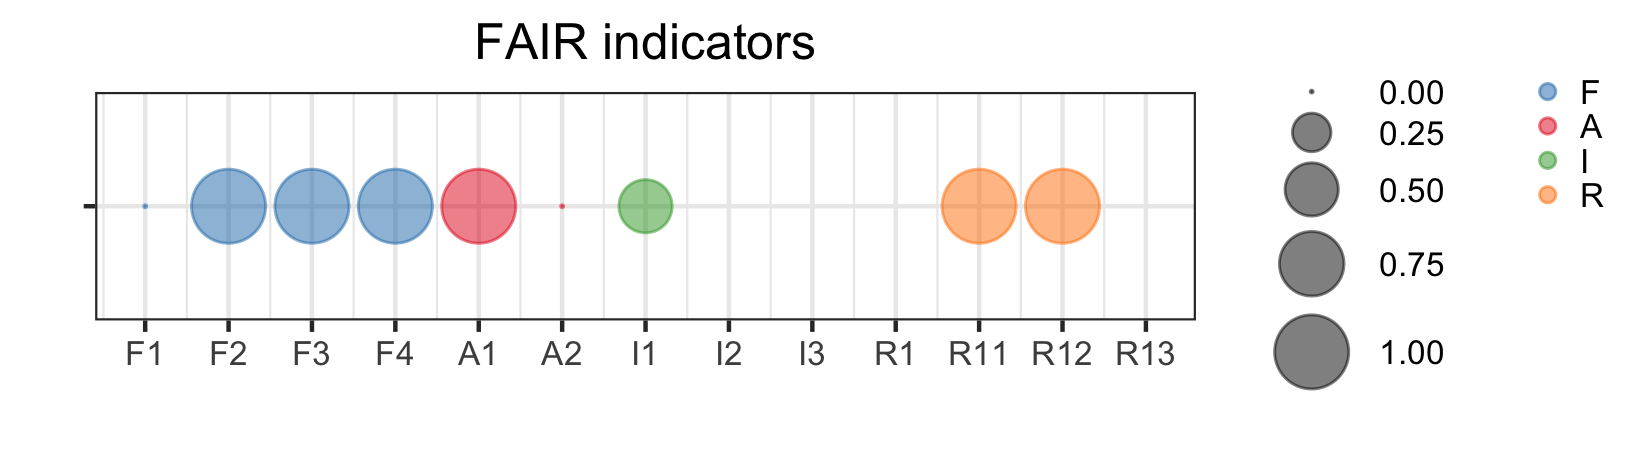

In [29]:
%%R -i df -w 5.5 -h 1.5 --units in -r 300 

library(ggplot2)

title_text_size <- 12
axis_text_size  <- 10
tick_text_size  <- 8

# variables
metric_names <- c("F1", "F2", "F3", "F4", "A1", "A2", "I1", "I2", "I3", "R1", "R11", "R12", "R13" )
x_values     <- rep(1, length(metric_names))
y_values     <- seq(1, length(metric_names))
y_values     <- sort(y_values, decreasing = TRUE)
point_color  <- c("F",  "F",  "F",  "F",  "A",  "A",  "I",  "I",  "I",  "R",  "R",   "R",   "R"  )

pl <- ggplot(data=df, aes(x=x_values, y=y_values, color=point_color, size=metric_values))+
        # points
        geom_point(alpha=0.5) +
        scale_size(range = c(0, 8)) + 
        #scale_size_area(max_size = 6) + 
        # background
        theme_bw() + 
        # flip x and y
        coord_flip()  +
        # axis ticks (x and y flipped)
        scale_x_continuous(limits=c(0,2),   breaks=seq(1,1,0),   labels="") + 
        scale_y_reverse   (limits=c(13, 1), breaks=seq(13,1,-1), labels=metric_names) + 
        theme(axis.text.x = element_text(size = tick_text_size)) + 
        theme(axis.text.y = element_text(size = tick_text_size)) +
        # axis text
        xlab ("") +
        ylab ("") +
        theme(text = element_text( size = axis_text_size )) + 
        # change colors
        scale_color_manual(values=c("#e31a1c", "#1f78b4", "#33a02c", "#ff7f00"),
                         labels = c("F", "A", "I", "R"),
                         breaks = c("F", "A", "I", "R")
                         ) +  
        # title
        ggtitle("FAIR indicators") +
        theme(plot.title = element_text(size = title_text_size, hjust = 0.5))  +
        # legend - colors
        theme(legend.text = element_text(size=tick_text_size),
              legend.key.size = unit(0.2, "cm")) + 
        labs(color="") +  # no legend title   
        labs(size="")  +  # no legend title
        theme(legend.box = "horizontal") 
        

# display
pl

---


## Dependencies 

In [30]:
%reload_ext watermark
%watermark -v -m -p bs4,os,pandas,requests,xml.etree.ElementTree,io

CPython 3.7.3
IPython 7.4.0

bs4 4.7.1
os unknown
pandas 0.24.2
requests 2.21.0
xml.etree.ElementTree unknown
io unknown

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [31]:
%%R
sessionInfo()

R version 3.3.3 (2017-03-06)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS  10.13.6

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] ggplot2_3.1.0

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.1       digest_0.6.18    withr_2.1.2      crayon_1.3.4    
 [5] dplyr_0.8.1      assertthat_0.2.1 grid_3.3.3       plyr_1.8.4      
 [9] R6_2.4.0         gtable_0.2.0     magrittr_1.5     scales_1.0.0    
[13] pillar_1.4.0     rlang_0.3.4      lazyeval_0.2.1   labeling_0.3    
[17] glue_1.3.1       purrr_0.3.2      munsell_0.5.0    pkgconfig_2.0.2 
[21] colorspace_1.3-2 tidyselect_0.2.5 tibble_2.1.1    


In [32]:
# import datetime
# now = datetime.datetime.now()
# print ("Date: " + str(now.day) + " " + str(now.month) + " " + str(now.year))
%watermark -u -n -t -z

Date: 3 7 2019
